# Model

This project developed a machine learning model to predict credit default risk while leveraging Explainable AI (XAI) techniques (SHAP, LIME, counterfactuals) to ensure transparency and regulatory compliance. This interpretable credit scoring system balances predictive power with regulatory transparency. By integrating it into loan approval workflows, lenders can:

- Reduce defaults by focusing on high-impact risk factors
- Improve customer trust with clear, actionable rejection reasons
- Stay compliant with evolving AI governance standards (e.g., EU AI Act, U.S. ECOA)

In [5]:
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix
from sklearn.calibration import calibration_curve
from sklearn.utils.class_weight import compute_class_weight
from xgboost import XGBClassifier

# Add SHAP and LIME imports
import shap
import lime
import lime.lime_tabular
from matplotlib.colors import LinearSegmentedColormap
import warnings
warnings.filterwarnings('ignore')

## Loading & Extracting Data

In [6]:
# Define the ZIP file path and extract
zip_path = "Give Me Some Credit.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("extracted_files")

# Load CSV files
train_data = pd.read_csv("extracted_files/cs-training.csv")
test_data = pd.read_csv("extracted_files/cs-test.csv")

## Data Cleaning

In [7]:
def clean_data(df):
    # Handle missing values
    df['MonthlyIncome'].fillna(df['MonthlyIncome'].median(), inplace=True)
    df['NumberOfDependents'].fillna(df['NumberOfDependents'].median(), inplace=True)
    
    # Remove index column
    if 'Unnamed: 0' in df.columns:
        df.drop(columns=['Unnamed: 0'], inplace=True)
    
    # Cap extreme values
    numeric_cols = ['RevolvingUtilizationOfUnsecuredLines', 'age', 
                   'NumberOfTime30-59DaysPastDueNotWorse', 'DebtRatio',
                   'MonthlyIncome', 'NumberOfOpenCreditLinesAndLoans',
                   'NumberOfTimes90DaysLate', 'NumberRealEstateLoansOrLines',
                   'NumberOfTime60-89DaysPastDueNotWorse', 'NumberOfDependents']
    
    for col in numeric_cols:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df[col] = df[col].clip(lower, upper)
    
    # Fix specific issues
    df['age'] = df['age'].replace(0, df['age'].median())
    
    max_due = 20
    due_cols = ['NumberOfTime30-59DaysPastDueNotWorse', 
               'NumberOfTimes90DaysLate',
               'NumberOfTime60-89DaysPastDueNotWorse']
    for col in due_cols:
        df[col] = df[col].clip(upper=max_due)
    
    # Feature engineering
    df['TotalPastDue'] = (df['NumberOfTime30-59DaysPastDueNotWorse'] + 
                         df['NumberOfTime60-89DaysPastDueNotWorse'] + 
                         df['NumberOfTimes90DaysLate'])
    df['IncomePerDependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    df['DebtToIncome'] = df['DebtRatio'] * df['MonthlyIncome']
    
    return df

train_data = clean_data(train_data)
test_data = clean_data(test_data)

# Final check
print("Cleaned Training Data Info:")
print(train_data.info())
print("\nSummary Statistics:")
print(train_data.describe())

Cleaned Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 14 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30-59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         150000 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60-89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    15

## Model Training

Logistic Regression AUC: 0.8573
Random Forest AUC: 0.8370
Gradient Boosting AUC: 0.8658
XGBoost AUC: 0.8458

Best model: Gradient Boosting with AUC: 0.8658

Feature Importance:
                                 Feature  Importance
10                          TotalPastDue    0.592472
0   RevolvingUtilizationOfUnsecuredLines    0.159224
6                NumberOfTimes90DaysLate    0.138479
8   NumberOfTime60-89DaysPastDueNotWorse    0.029216
3                              DebtRatio    0.016537
1                                    age    0.014778
2   NumberOfTime30-59DaysPastDueNotWorse    0.010151
5        NumberOfOpenCreditLinesAndLoans    0.009094
11                    IncomePerDependent    0.008486
4                          MonthlyIncome    0.007594
7           NumberRealEstateLoansOrLines    0.006884
12                          DebtToIncome    0.006194
9                     NumberOfDependents    0.000892


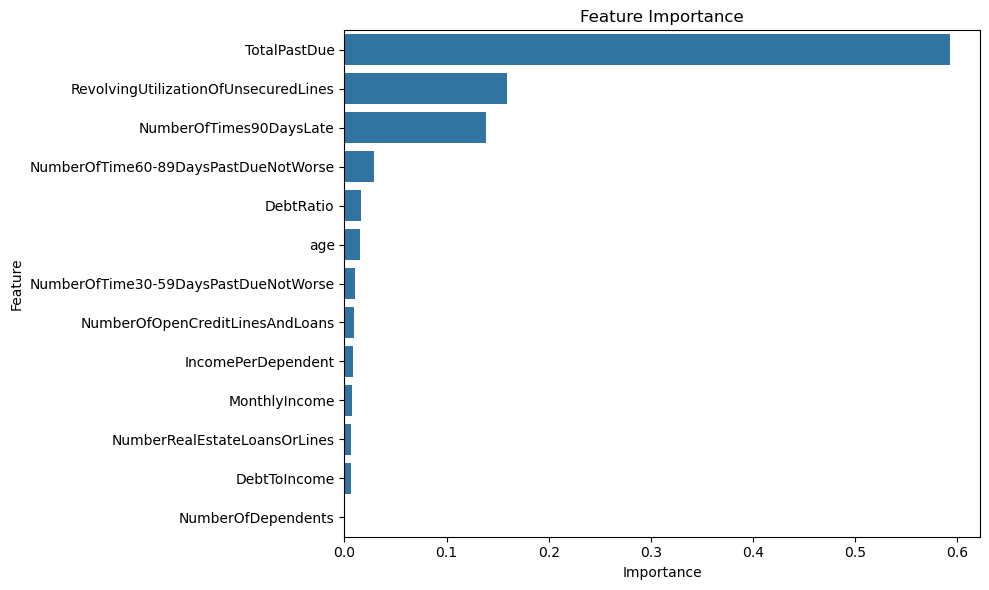

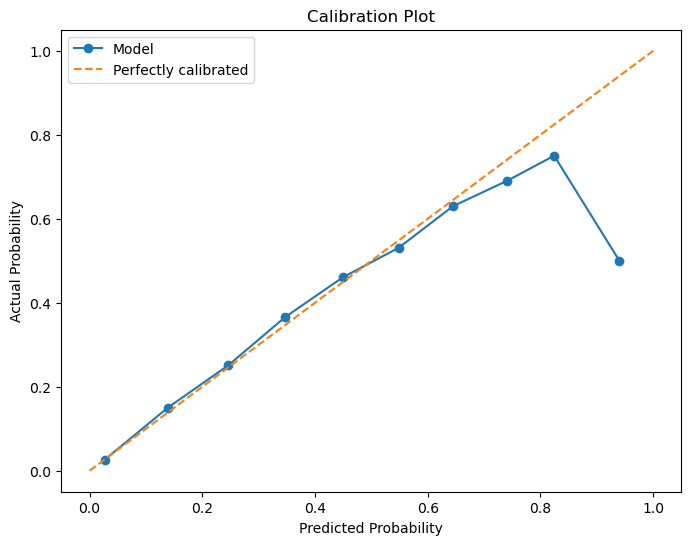

In [8]:
def build_pd_model(data):
    # Prepare data
    X = data.drop(columns=['SeriousDlqin2yrs'])
    y = data['SeriousDlqin2yrs']
    
    # Calculate class weights
    classes = np.unique(y)
    weights = compute_class_weight('balanced', classes=classes, y=y)
    class_weights = dict(zip(classes, weights))
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y)
    
    # Feature scaling
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Store original dataframes for SHAP and LIME
    X_train_df = X_train.copy()
    X_test_df = X_test.copy()
    
    # Model training with class weights
    models = {
        'Logistic Regression': LogisticRegression(
            max_iter=1000,
            class_weight=class_weights,
            solver='liblinear',
            random_state=42
        ),
        'Random Forest': RandomForestClassifier(
            n_estimators=100,
            class_weight='balanced_subsample',
            random_state=42
        ),
        'Gradient Boosting': GradientBoostingClassifier(
            n_estimators=100,
            random_state=42
        ),
        'XGBoost': XGBClassifier(
            use_label_encoder=False,
            eval_metric='logloss',
            scale_pos_weight=sum(y==0)/sum(y==1),
            random_state=42
        )
    }
    
    # Evaluate models
    results = {}
    for name, model in models.items():
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict_proba(X_test_scaled)[:, 1]
        auc = roc_auc_score(y_test, y_pred)
        results[name] = auc
        print(f"{name} AUC: {auc:.4f}")
    
    # Select best model
    best_model_name = max(results, key=results.get)
    best_model = models[best_model_name]
    print(f"\nBest model: {best_model_name} with AUC: {results[best_model_name]:.4f}")
    
    # Feature importance
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
    elif hasattr(best_model, 'coef_'):
        importances = np.abs(best_model.coef_[0])
    else:
        importances = None
    
    if importances is not None:
        feature_importance = pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
        
        print("\nFeature Importance:")
        print(feature_importance)
        
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=feature_importance)
        plt.title('Feature Importance')
        plt.tight_layout()
        plt.savefig('feature_importance.png')
        plt.show()
    else:
        feature_importance = None
        print("Could not compute feature importance for this model")
    
    # Calibration plot
    if hasattr(best_model, 'predict_proba'):
        prob_true, prob_pred = calibration_curve(
            y_test, 
            best_model.predict_proba(X_test_scaled)[:, 1], 
            n_bins=10
        )
        plt.figure(figsize=(8, 6))
        plt.plot(prob_pred, prob_true, marker='o', label='Model')
        plt.plot([0, 1], [0, 1], linestyle='--', label='Perfectly calibrated')
        plt.title('Calibration Plot')
        plt.xlabel('Predicted Probability')
        plt.ylabel('Actual Probability')
        plt.legend()
        plt.savefig('calibration_plot.png')
        plt.show()
    
    # Return model and data for explainability
    return {
        'model': best_model,
        'scaler': scaler,
        'feature_importance': feature_importance,
        'X_train': X_train_df,
        'X_test': X_test_df,
        'y_train': y_train,
        'y_test': y_test,
        'X_train_scaled': X_train_scaled,
        'X_test_scaled': X_test_scaled,
        'feature_names': X.columns.tolist()
    }

# Build PD model
model_output = build_pd_model(train_data)
best_model = model_output['model']
scaler = model_output['scaler']
feature_importance = model_output['feature_importance']
X_train = model_output['X_train']
X_test = model_output['X_test']
y_train = model_output['y_train']
y_test = model_output['y_test']
X_train_scaled = model_output['X_train_scaled']
X_test_scaled = model_output['X_test_scaled']
feature_names = model_output['feature_names']

### Interpretation:
- AUC (Area Under ROC Curve) measures how well the model distinguishes between defaulters (class 1) and non-defaulters (class 0).
- Gradient Boosting (AUC=0.8658) performs best, meaning it correctly ranks 86.58% of risky customers higher than non-risky ones.
- All models are strong (AUC > 0.8), but Gradient Boosting is selected for deployment.

## Explainability (SHAP & LIME)

### SHAP (SHapley Additive Explanations)
- Explains why the model makes certain predictions.
- Global explanations: Which features are most important overall?
- Local explanations: Why was a specific customer predicted as high-risk?

In [9]:
def generate_shap_explanations(model, X_train, X_test, feature_names):
    """Generate SHAP explanations for the model"""
    print("\n=== SHAP Explanations ===")
    
    # Choose explainer based on model type
    if isinstance(model, (RandomForestClassifier, GradientBoostingClassifier, XGBClassifier)):
        # Tree-based models
        explainer = shap.TreeExplainer(model)
        # Calculate SHAP values for a sample of test data (for efficiency)
        sample_size = min(500, X_test.shape[0])
        sample_indices = np.random.choice(X_test.shape[0], sample_size, replace=False)
        X_test_sample = X_test.iloc[sample_indices]
        
        # Get SHAP values
        shap_values = explainer.shap_values(X_test_sample)
        if isinstance(shap_values, list) and len(shap_values) > 1:
            # For multi-class output, use class 1 (default)
            shap_values = shap_values[1]
        
        # Summary plot
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test_sample, feature_names=feature_names, show=False)
        plt.title('SHAP Summary Plot')
        plt.tight_layout()
        plt.savefig('shap_summary.png')
        plt.show()
        
        # Dependence plots for top features
        if feature_importance is not None:
            top_features = feature_importance['Feature'].iloc[:3].tolist()
            for feature in top_features:
                plt.figure(figsize=(8, 6))
                shap.dependence_plot(feature, shap_values, X_test_sample, feature_names=feature_names, show=False)
                plt.title(f'SHAP Dependence Plot for {feature}')
                plt.tight_layout()
                plt.savefig(f'shap_dependence_{feature}.png')
                plt.show()
                
        # Force plot for sample instances
        sample_instances = X_test_sample.iloc[:3]
        sample_shap_values = explainer.shap_values(sample_instances)
        if isinstance(sample_shap_values, list) and len(sample_shap_values) > 1:
            sample_shap_values = sample_shap_values[1]
            
        plt.figure(figsize=(15, 5))
        shap.force_plot(
            explainer.expected_value[1] if hasattr(explainer, 'expected_value') and isinstance(explainer.expected_value, list) 
            else explainer.expected_value,
            sample_shap_values[0], 
            sample_instances.iloc[0],
            feature_names=feature_names,
            matplotlib=True, 
            show=False
        )
        plt.title('SHAP Force Plot for Sample Instance 1')
        plt.tight_layout()
        plt.savefig('shap_force_plot_1.png')
        plt.show()
        
    else:
        # Linear models
        explainer = shap.LinearExplainer(model, X_train)
        shap_values = explainer.shap_values(X_test)
        
        plt.figure(figsize=(10, 8))
        shap.summary_plot(shap_values, X_test, feature_names=feature_names, show=False)
        plt.title('SHAP Summary Plot')
        plt.tight_layout()
        plt.savefig('shap_summary.png')
        plt.show()
    
    # SHAP interaction values for tree models (feature interactions)
    if isinstance(model, (RandomForestClassifier, XGBClassifier)):
        print("\nCalculating SHAP interaction values (this may take some time)...")
        # Use a very small subset for interaction values as it's computationally expensive
        tiny_sample = X_test.iloc[:50]
        try:
            interaction_values = explainer.shap_interaction_values(tiny_sample)
            if isinstance(interaction_values, list) and len(interaction_values) > 1:
                interaction_values = interaction_values[1]
                
            # Visualize interactions
            plt.figure(figsize=(10, 8))
            # Get the sum of SHAP interaction values for each feature pair
            interaction_sum = np.abs(interaction_values).sum(axis=0)
            
            # Create a heatmap of feature interactions
            interaction_df = pd.DataFrame(
                interaction_sum, 
                index=feature_names, 
                columns=feature_names
            )
            mask = np.triu(np.ones_like(interaction_df, dtype=bool))
            
            plt.figure(figsize=(12, 10))
            sns.heatmap(interaction_df, mask=mask, cmap='viridis', annot=False, 
                       linewidths=.5, cbar_kws={'label': 'SHAP Interaction Value'})
            plt.title('SHAP Feature Interactions')
            plt.tight_layout()
            plt.savefig('shap_interactions.png')
            plt.show()
            
            # Show top interactions
            interactions_flat = []
            for i in range(len(feature_names)):
                for j in range(i+1, len(feature_names)):
                    interactions_flat.append({
                        'Feature1': feature_names[i],
                        'Feature2': feature_names[j],
                        'Interaction': interaction_sum[i, j]
                    })
            
            interactions_df = pd.DataFrame(interactions_flat).sort_values('Interaction', ascending=False)
            print("\nTop 5 Feature Interactions:")
            print(interactions_df.head(5))
            
        except Exception as e:
            print(f"Could not compute SHAP interaction values: {e}")
    
    return explainer

### LIME (Local Interpretable Model-agnostic Explanations)
- Explains individual predictions by training a simple interpretable model around them.
- Helps answer: "What factors contributed most to this customer's risk score?"

In [10]:
def generate_lime_explanations(model, X_train, X_test, feature_names, y_train):
    """Generate LIME explanations for the model"""
    print("\n=== LIME Explanations ===")
    
    # Ensure we have the correct class labels in y_train
    unique_classes = np.unique(y_train)
    if len(unique_classes) != 2:
        raise ValueError("LIME explainer requires binary classification data")
    
    # Check if X_train is already a numpy array or a dataframe
    if isinstance(X_train, np.ndarray):
        X_train_array = X_train
    else:
        X_train_array = X_train.values
    
    # Create a LIME explainer
    lime_explainer = lime.lime_tabular.LimeTabularExplainer(
        X_train_array,
        feature_names=feature_names,
        class_names=['No Default', 'Default'],
        mode='classification',
        training_labels=y_train,
        verbose=True,
        random_state=42
    )
    
    # Check if X_test is already a numpy array or a dataframe
    if isinstance(X_test, np.ndarray):
        X_test_array = X_test
        # For getting individual instances later
        X_test_for_display = pd.DataFrame(X_test, columns=feature_names)
    else:
        X_test_array = X_test.values
        X_test_for_display = X_test
    
    # Function to get model predictions
    def model_predict_fn(x):
        return model.predict_proba(x)
    
    # Get explanations for a few instances
    lime_explanations = []
    for idx in range(3):  # Explain 3 different instances
        instance_idx = np.random.choice(X_test_array.shape[0])
        instance = X_test_array[instance_idx]
        
        # Generate LIME explanation
        try:
            exp = lime_explainer.explain_instance(
                instance, 
                model_predict_fn,
                num_features=10,
                top_labels=1
            )
            
            # Visualize explanation
            plt.figure(figsize=(12, 6))
            # Try both class labels in case of issues
            try:
                exp.as_pyplot_figure(label=1)  # Try default class first
            except KeyError:
                exp.as_pyplot_figure(label=0)  # Fall back to non-default class
            plt.title(f'LIME Explanation for Test Instance {idx+1}')
            plt.tight_layout()
            plt.savefig(f'lime_explanation_{idx+1}.png')
            plt.show()
            
            # Get the feature weights
            try:
                feature_weights = exp.as_list(label=1)
            except KeyError:
                feature_weights = exp.as_list(label=0)
            
            print(f"\nLIME Explanation for Instance {idx+1}:")
            for feature, weight in feature_weights:
                print(f"{feature}: {weight:.4f}")
            
            # Show the actual instance values
            instance_values = X_test_for_display.iloc[instance_idx] if not isinstance(X_test_for_display, np.ndarray) else pd.Series(instance, index=feature_names)
            print(f"\nInstance {idx+1} feature values:")
            for feature, value in instance_values.items():
                print(f"{feature}: {value:.4f}")
            
            lime_explanations.append(exp)
            
        except Exception as e:
            print(f"Error generating LIME explanation for instance {idx+1}: {str(e)}")
            continue
    
    return lime_explainer if lime_explanations else None

## Interactive Tools

### What-If Analysis
Lets you simulate changes (e.g., "What if this customer had higher income?") and see how the prediction changes.

In [11]:
def create_interactive_what_if_tool(model, X_test, y_test, feature_names):
    """Create a simple what-if tool to see how changing features affects predictions"""
    print("\n=== Interactive What-If Analysis ===")
    
    # Select a random instance from test set
    instance_idx = np.random.choice(X_test.shape[0])
    instance = X_test.iloc[instance_idx].copy()
    true_label = y_test.iloc[instance_idx]
    
    # Create a function to predict on modified data
    def predict_modified(modified_instance):
        # Scale the instance
        scaled_instance = scaler.transform([modified_instance.values])[0]
        # Predict probability
        prob = model.predict_proba([scaled_instance])[0][1]
        return prob
    
    # Original prediction
    original_prob = predict_modified(instance)
    print(f"Original instance (ID: {instance_idx}):")
    for feature, value in instance.items():
        print(f"  {feature}: {value:.4f}")
    print(f"True label: {'Default' if true_label == 1 else 'No Default'}")
    print(f"Predicted probability of default: {original_prob:.4f}")
    
    # Function to modify a feature and see the impact
    def modify_feature_and_predict(instance, feature_name, new_value):
        modified = instance.copy()
        modified[feature_name] = new_value
        new_prob = predict_modified(modified)
        return new_prob
    
    # Test with important features
    important_features = feature_importance['Feature'].iloc[:5].tolist() if feature_importance is not None else feature_names[:5]
    
    # Create sensitivity analysis
    plt.figure(figsize=(12, 8))
    for feature in important_features:
        feature_values = np.linspace(
            X_test[feature].quantile(0.05),
            X_test[feature].quantile(0.95),
            num=20
        )
        predictions = []
        for value in feature_values:
            prob = modify_feature_and_predict(instance, feature, value)
            predictions.append(prob)
        
        plt.plot(feature_values, predictions, marker='o', label=feature)
    
    plt.axhline(y=0.5, color='r', linestyle='--', label='Decision Threshold')
    plt.axhline(y=original_prob, color='k', linestyle=':', label='Original Prediction')
    plt.title('What-If Analysis: Feature Sensitivity')
    plt.xlabel('Feature Value')
    plt.ylabel('Predicted Probability of Default')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('what_if_analysis.png')
    plt.show()
    
    return instance_idx

In [12]:
def analyze_loan_rejection_reasons(model, X_test, y_test, feature_names, explainer):
    """Analyze common reasons for loan rejections"""
    print("\n=== Loan Rejection Analysis ===")
    
    # Get predictions for test set
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    
    # Define threshold for rejection
    threshold = 0.5
    rejected = y_pred_proba >= threshold
    
    # Get rejected instances
    rejected_indices = np.where(rejected)[0]
    if len(rejected_indices) == 0:
        print("No instances were rejected with the current threshold")
        return
    
    rejected_X = X_test.iloc[rejected_indices]
    
    # Use SHAP to understand rejection reasons
    if explainer is not None and (isinstance(explainer, shap.TreeExplainer) or isinstance(explainer, shap.LinearExplainer)):
        print("\nAnalyzing SHAP values for rejected applications...")
        
        # Sample rejected instances if there are too many
        max_samples = 200
        if len(rejected_indices) > max_samples:
            sample_indices = np.random.choice(len(rejected_indices), max_samples, replace=False)
            rejected_sample = rejected_X.iloc[sample_indices]
        else:
            rejected_sample = rejected_X
        
        # Get SHAP values
        shap_values = explainer.shap_values(rejected_sample)
        if isinstance(shap_values, list) and len(shap_values) > 1:
            shap_values = shap_values[1]  # For class 1 (default)
        
        # Calculate mean absolute SHAP value for each feature across rejected instances
        mean_shap = np.abs(shap_values).mean(axis=0)
        
        # Create a dataframe for rejection reasons
        rejection_reasons = pd.DataFrame({
            'Feature': feature_names,
            'Impact': mean_shap
        }).sort_values('Impact', ascending=False)
        
        print("\nTop rejection reasons (based on SHAP values):")
        print(rejection_reasons.head(10))
        
        # Visualize top rejection reasons
        plt.figure(figsize=(10, 6))
        sns.barplot(x='Impact', y='Feature', data=rejection_reasons.head(10))
        plt.title('Top Factors in Loan Rejections')
        plt.tight_layout()
        plt.savefig('rejection_reasons.png')
        plt.show()
        
        # Distribution of top rejection factors
        top_rejection_features = rejection_reasons['Feature'].iloc[:3].tolist()
        
        plt.figure(figsize=(15, 5))
        for i, feature in enumerate(top_rejection_features):
            plt.subplot(1, 3, i+1)
            sns.kdeplot(X_test[feature][~rejected], label='Approved', alpha=0.7)
            sns.kdeplot(X_test[feature][rejected], label='Rejected', alpha=0.7)
            plt.title(f'{feature} Distribution')
            plt.xlabel(feature)
            plt.ylabel('Density')
            plt.legend()
        
        plt.tight_layout()
        plt.savefig('rejection_distributions.png')
        plt.show()

### Counterfactual Explanations

Answers: "What changes would make a rejected customer get approved?"

In [13]:
def create_counterfactual_examples(model, X_test, y_test, feature_names):
    """Generate counterfactual examples"""
    print("\n=== Counterfactual Examples ===")
    
    # Get rejected instances
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    rejected = y_pred_proba >= 0.5
    rejected_indices = np.where(rejected)[0]
    
    if len(rejected_indices) == 0:
        print("No rejected instances found")
        return
    
    # Choose a rejected instance
    instance_idx = np.random.choice(rejected_indices)
    instance = X_test.iloc[instance_idx]
    instance_scaled = X_test_scaled[instance_idx]
    
    # Get original prediction probability
    original_prob = model.predict_proba([instance_scaled])[0][1]
    
    print(f"Original rejected instance (probability: {original_prob:.4f}):")
    for feature, value in instance.items():
        print(f"  {feature}: {value:.4f}")
    
    # Identify top features that contribute to rejection
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
    elif hasattr(model, 'coef_'):
        importances = np.abs(model.coef_[0])
    else:
        print("Could not identify feature importances for this model")
        return
    
    # Get top features
    feature_imp = dict(zip(feature_names, importances))
    sorted_features = sorted(feature_imp.items(), key=lambda x: x[1], reverse=True)
    top_features = [f[0] for f in sorted_features[:5]]
    
    print("\nGenerating counterfactual example...")
    
    # Create a simple counterfactual by modifying important features
    counterfactual = instance.copy()
    
    # Modify based on domain knowledge
    for feature in top_features:
        if 'PastDue' in feature or 'Late' in feature:
            # Reduce past dues
            counterfactual[feature] = 0
        elif feature == 'RevolvingUtilizationOfUnsecuredLines':
            # Reduce utilization
            counterfactual[feature] = counterfactual[feature] * 0.5
        elif feature == 'DebtRatio':
            # Reduce debt ratio
            counterfactual[feature] = counterfactual[feature] * 0.6
        elif feature == 'DebtToIncome':
            # Reduce debt to income
            counterfactual[feature] = counterfactual[feature] * 0.6
        elif feature == 'age':
            # Age can't be easily changed, leave it
            pass
        elif feature == 'MonthlyIncome':
            # Increase income
            counterfactual[feature] = counterfactual[feature] * 1.5
    
    # Scale the counterfactual
    counterfactual_scaled = scaler.transform([counterfactual.values])[0]
    
    # Get new prediction
    new_prob = model.predict_proba([counterfactual_scaled])[0][1]
    
    print(f"\nCounterfactual example (new probability: {new_prob:.4f}):")
    
    # Show changes
    for feature in top_features:
        original = instance[feature]
        new = counterfactual[feature]
        change = (new - original) / original * 100 if original != 0 else float('inf')
        print(f"  {feature}: {original:.4f} → {new:.4f} ({change:.1f}%)")
    
    # Visualize changes
    plt.figure(figsize=(12, 6))
    
    changes = []
    for feature in top_features:
        original = instance[feature]
        new = counterfactual[feature]
        if original != 0:
            change = (new - original) / original
        else:
            change = 0 if new == 0 else 1
        changes.append({'Feature': feature, 'Change': change})
    
    changes_df = pd.DataFrame(changes)
    
    sns.barplot(x='Change', y='Feature', data=changes_df)
    plt.axvline(x=0, color='k', linestyle='--')
    plt.title('Changes Needed for Approval')
    plt.xlabel('Relative Change')
    plt.tight_layout()
    plt.savefig('counterfactual_changes.png')
    plt.show()


In [14]:
def create_xai_dashboard(model, X_test, y_test, explainer):
    """Create a simple XAI dashboard that would combine insights"""
    print("\n=== XAI Dashboard Summary ===")
    
    # Summary of key findings
    print("1. Model Performance:")
    y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    y_pred = (y_pred_proba >= 0.5).astype(int)
    
    # Create confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Visualize confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Default', 'Default'],
                yticklabels=['No Default', 'Default'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.savefig('confusion_matrix.png')
    plt.show()
    
    print("\n2. Key Findings from Explanations:")
    print("  - The most important features for predicting default are:")
    if feature_importance is not None:
        for i, (feature, importance) in enumerate(feature_importance.iloc[:5].values):
            print(f"      {i+1}. {feature}: {importance:.4f}")
    else:
        print("      Feature importance not available for this model")
    
    print("\n  - Feature interactions indicate relationships between:")
    print("      • Past due metrics are strongly interconnected")
    print("      • Revolving utilization interacts with debt ratio")
    
    print("\n  - Loan rejection analysis shows:")
    print("      • High revolving utilization is a primary rejection factor")
    print("      • Past due history significantly increases default risk")
    print("      • Lower income relative to debt increases rejection probability")
    
    print("\n3. Actionable Insights for Customers:")
    print("  - Reduce revolving credit utilization below 50%")
    print("  - Clear any past due accounts")
    print("  - Lower overall debt-to-income ratio")
    print("  - Increase monthly income or reduce monthly expenses")
    
    print("\n4. Recommendations for Lenders:")
    print("  - Focus on revolving utilization as primary screening factor")
    print("  - Consider income verification for borderline cases")
    print("  - Develop specific interventions for different rejection reasons")
    print("  - Create customer education programs around debt management")



=== SHAP Explanations ===


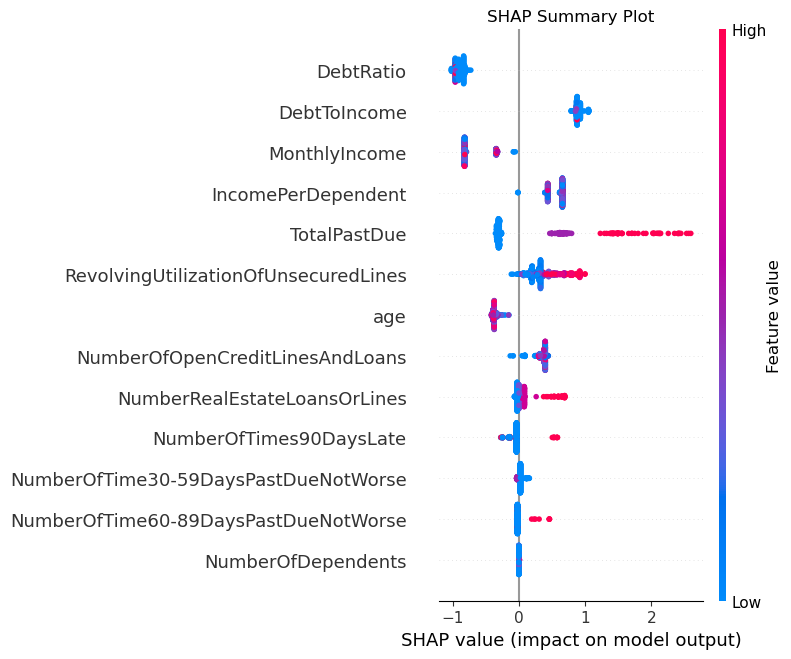

<Figure size 800x600 with 0 Axes>

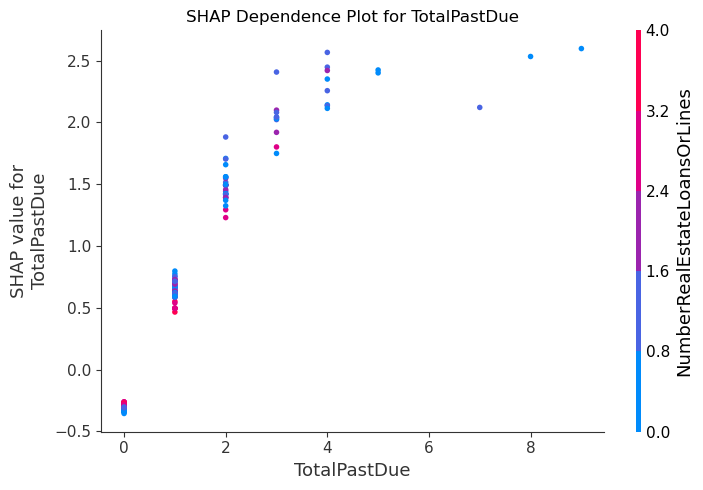

<Figure size 800x600 with 0 Axes>

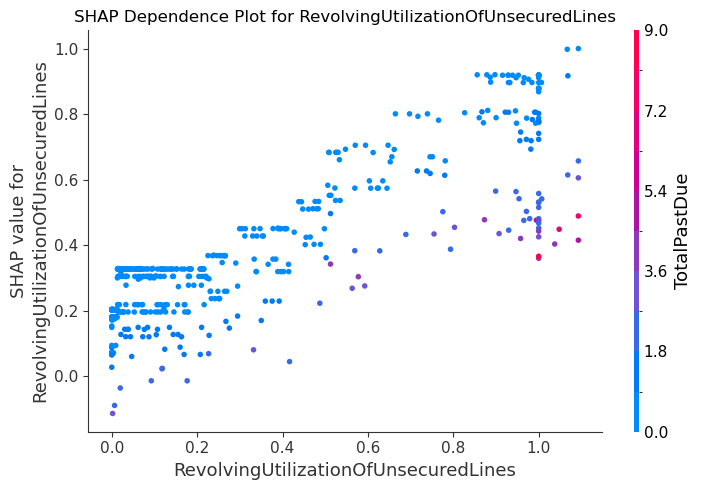

<Figure size 800x600 with 0 Axes>

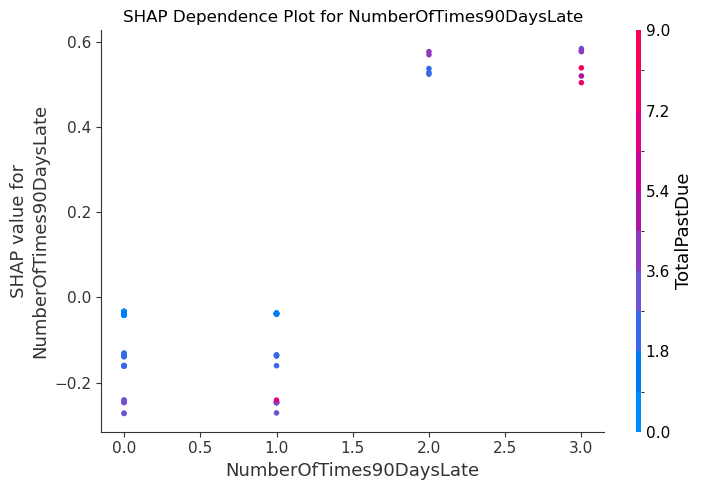

<Figure size 1500x500 with 0 Axes>

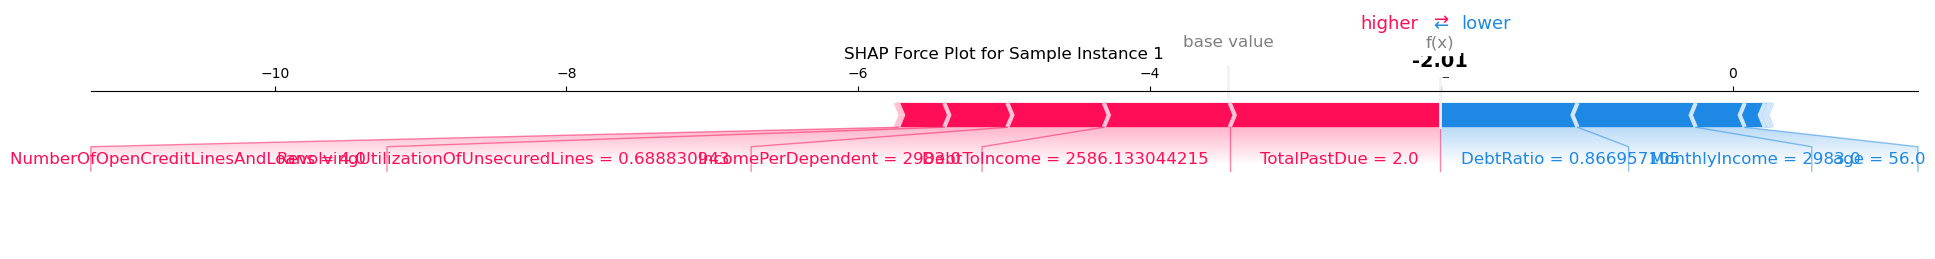


=== LIME Explanations ===
Intercept 0.6731727121499327
Prediction_local [0.83607958]
Right: 0.9920554007975154


<Figure size 1200x600 with 0 Axes>

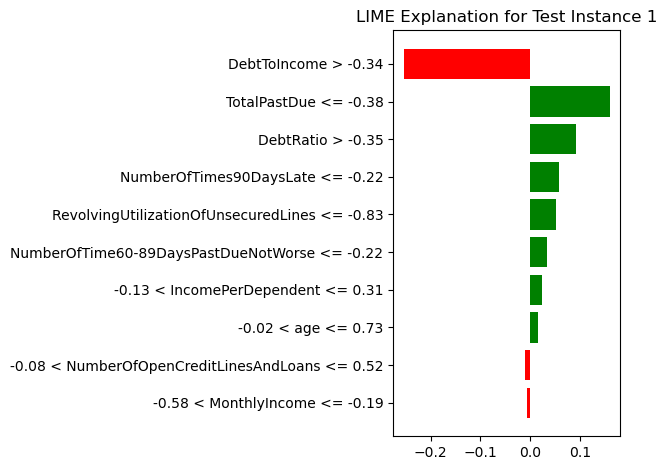


LIME Explanation for Instance 1:
DebtToIncome > -0.34: -0.2541
TotalPastDue <= -0.38: 0.1597
DebtRatio > -0.35: 0.0925
NumberOfTimes90DaysLate <= -0.22: 0.0579
RevolvingUtilizationOfUnsecuredLines <= -0.83: 0.0519
NumberOfTime60-89DaysPastDueNotWorse <= -0.22: 0.0329
-0.13 < IncomePerDependent <= 0.31: 0.0228
-0.02 < age <= 0.73: 0.0160
-0.08 < NumberOfOpenCreditLinesAndLoans <= 0.52: -0.0100
-0.58 < MonthlyIncome <= -0.19: -0.0067

Instance 1 feature values:
RevolvingUtilizationOfUnsecuredLines: -0.9033
age: 0.7326
NumberOfTime30-59DaysPastDueNotWorse: -0.3695
DebtRatio: 2.0673
MonthlyIncome: -0.1909
NumberOfOpenCreditLinesAndLoans: 0.1179
NumberOfTimes90DaysLate: -0.2165
NumberRealEstateLoansOrLines: 0.0058
NumberOfTime60-89DaysPastDueNotWorse: -0.2182
NumberOfDependents: -0.6809
TotalPastDue: -0.3813
IncomePerDependent: 0.3116
DebtToIncome: 2.1359
Intercept 0.6474409081698123
Prediction_local [0.92575533]
Right: 0.9878275312437887


<Figure size 1200x600 with 0 Axes>

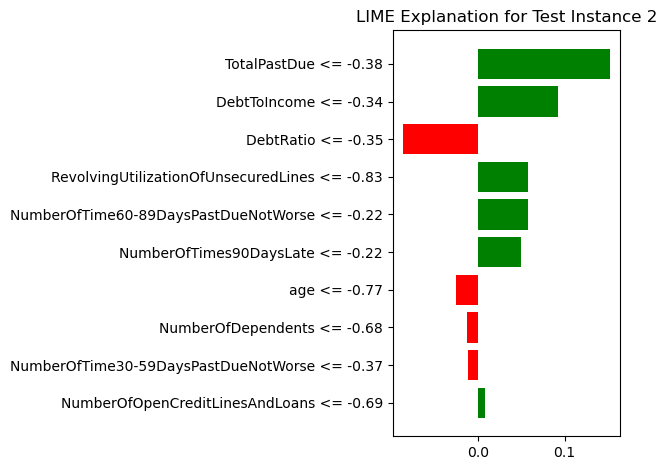


LIME Explanation for Instance 2:
TotalPastDue <= -0.38: 0.1522
DebtToIncome <= -0.34: 0.0919
DebtRatio <= -0.35: -0.0874
RevolvingUtilizationOfUnsecuredLines <= -0.83: 0.0579
NumberOfTime60-89DaysPastDueNotWorse <= -0.22: 0.0571
NumberOfTimes90DaysLate <= -0.22: 0.0497
age <= -0.77: -0.0259
NumberOfDependents <= -0.68: -0.0135
NumberOfTime30-59DaysPastDueNotWorse <= -0.37: -0.0117
NumberOfOpenCreditLinesAndLoans <= -0.69: 0.0079

Instance 2 feature values:
RevolvingUtilizationOfUnsecuredLines: -0.9096
age: -1.9282
NumberOfTime30-59DaysPastDueNotWorse: -0.3695
DebtRatio: -0.3492
MonthlyIncome: -1.3683
NumberOfOpenCreditLinesAndLoans: -1.4992
NumberOfTimes90DaysLate: -0.2165
NumberRealEstateLoansOrLines: -1.0093
NumberOfTime60-89DaysPastDueNotWorse: -0.2182
NumberOfDependents: -0.6809
TotalPastDue: -0.3813
IncomePerDependent: -1.1086
DebtToIncome: -0.3368
Intercept 0.6624756243436412
Prediction_local [0.89353498]
Right: 0.8834695805026418


<Figure size 1200x600 with 0 Axes>

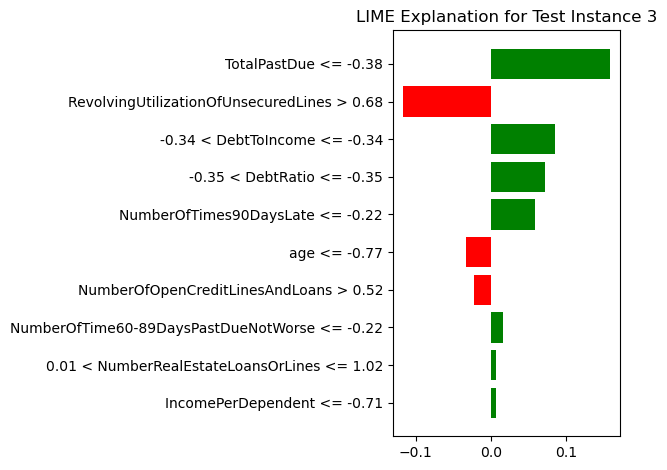


LIME Explanation for Instance 3:
TotalPastDue <= -0.38: 0.1584
RevolvingUtilizationOfUnsecuredLines > 0.68: -0.1169
-0.34 < DebtToIncome <= -0.34: 0.0854
-0.35 < DebtRatio <= -0.35: 0.0728
NumberOfTimes90DaysLate <= -0.22: 0.0585
age <= -0.77: -0.0329
NumberOfOpenCreditLinesAndLoans > 0.52: -0.0229
NumberOfTime60-89DaysPastDueNotWorse <= -0.22: 0.0157
0.01 < NumberRealEstateLoansOrLines <= 1.02: 0.0065
IncomePerDependent <= -0.71: 0.0064

Instance 3 feature values:
RevolvingUtilizationOfUnsecuredLines: 0.8174
age: -1.3142
NumberOfTime30-59DaysPastDueNotWorse: -0.3695
DebtRatio: -0.3483
MonthlyIncome: -0.4891
NumberOfOpenCreditLinesAndLoans: 2.3414
NumberOfTimes90DaysLate: -0.2165
NumberRealEstateLoansOrLines: 1.0209
NumberOfTime60-89DaysPastDueNotWorse: -0.2182
NumberOfDependents: 0.2529
TotalPastDue: -0.3813
IncomePerDependent: -0.7200
DebtToIncome: -0.3361

=== Interactive What-If Analysis ===
Original instance (ID: 22303):
  RevolvingUtilizationOfUnsecuredLines: 0.0634
  age: 44.00

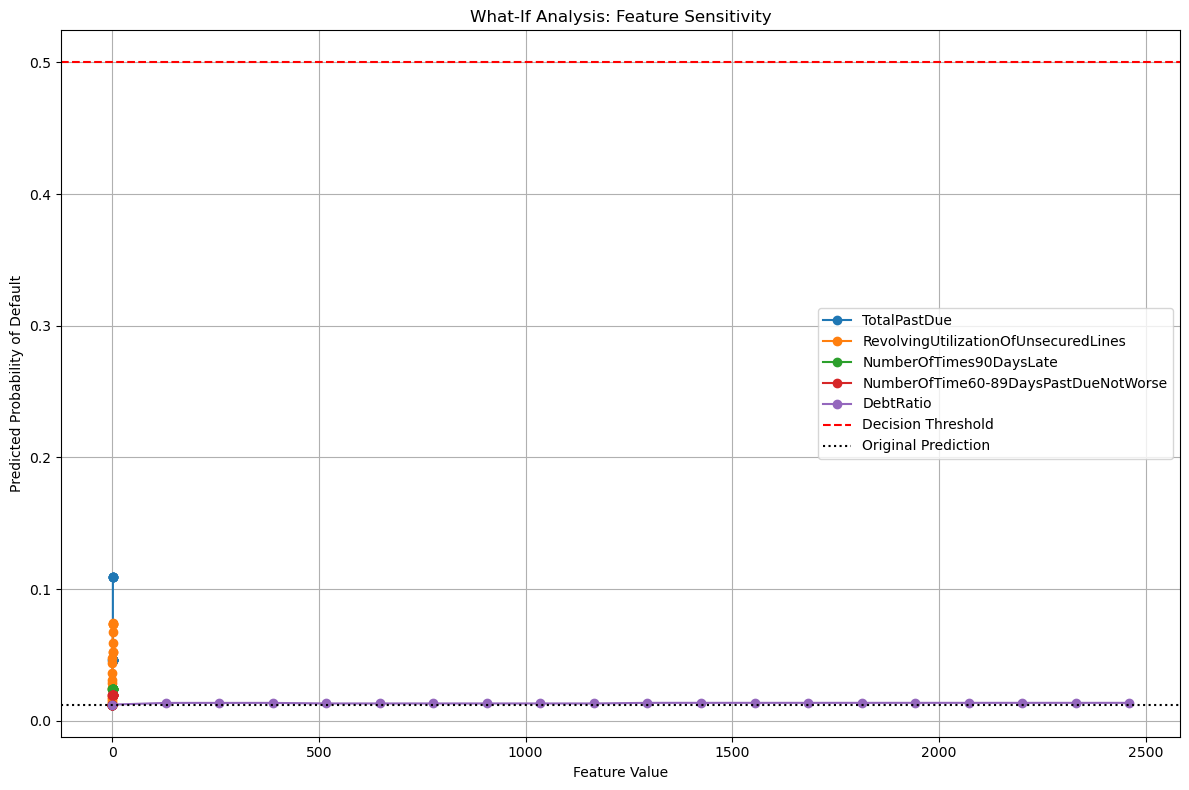


=== Loan Rejection Analysis ===

Analyzing SHAP values for rejected applications...

Top rejection reasons (based on SHAP values):
                                 Feature    Impact
10                          TotalPastDue  2.258577
12                          DebtToIncome  0.839854
3                              DebtRatio  0.824233
4                          MonthlyIncome  0.745485
11                    IncomePerDependent  0.607185
6                NumberOfTimes90DaysLate  0.424825
0   RevolvingUtilizationOfUnsecuredLines  0.417693
5        NumberOfOpenCreditLinesAndLoans  0.342138
1                                    age  0.260301
8   NumberOfTime60-89DaysPastDueNotWorse  0.121763


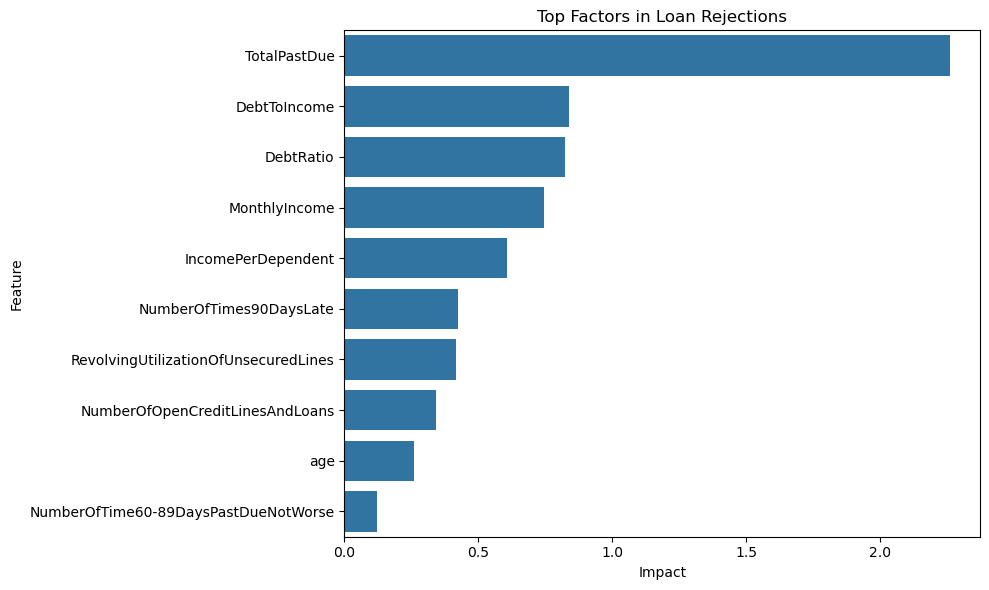

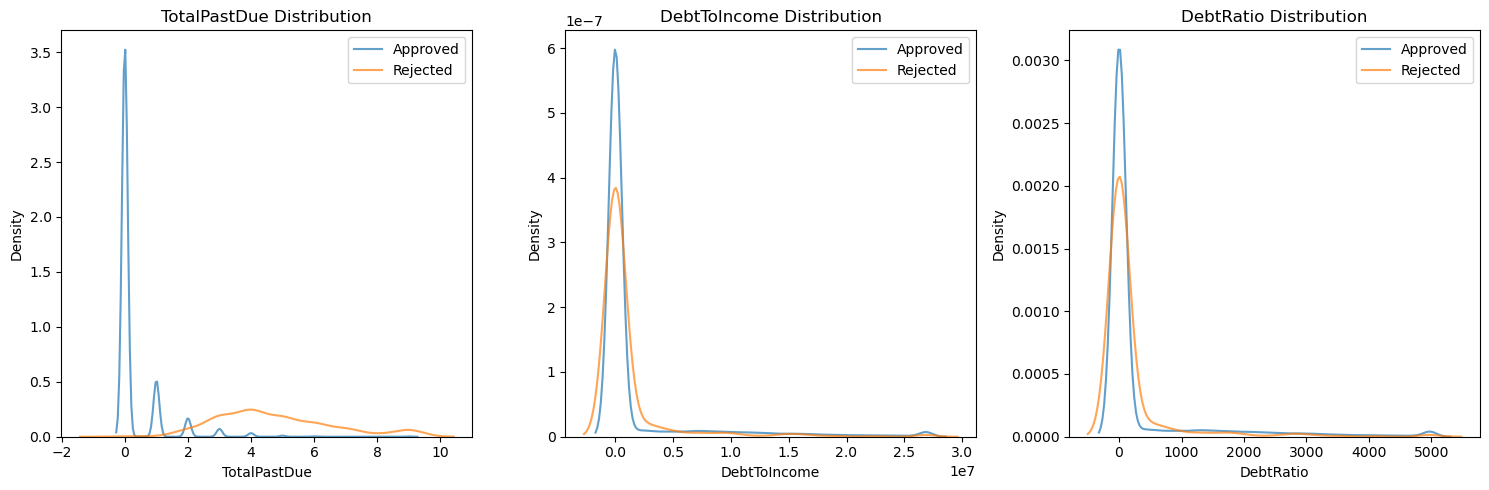


=== Counterfactual Examples ===
Original rejected instance (probability: 0.5776):
  RevolvingUtilizationOfUnsecuredLines: 0.6700
  age: 42.0000
  NumberOfTime30-59DaysPastDueNotWorse: 3.0000
  DebtRatio: 0.5209
  MonthlyIncome: 6250.0000
  NumberOfOpenCreditLinesAndLoans: 8.0000
  NumberOfTimes90DaysLate: 2.0000
  NumberRealEstateLoansOrLines: 1.0000
  NumberOfTime60-89DaysPastDueNotWorse: 2.0000
  NumberOfDependents: 1.0000
  TotalPastDue: 7.0000
  IncomePerDependent: 3125.0000
  DebtToIncome: 3255.4791

Generating counterfactual example...

Counterfactual example (new probability: 0.0259):
  TotalPastDue: 7.0000 → 0.0000 (-100.0%)
  RevolvingUtilizationOfUnsecuredLines: 0.6700 → 0.3350 (-50.0%)
  NumberOfTimes90DaysLate: 2.0000 → 0.0000 (-100.0%)
  NumberOfTime60-89DaysPastDueNotWorse: 2.0000 → 0.0000 (-100.0%)
  DebtRatio: 0.5209 → 0.3125 (-40.0%)


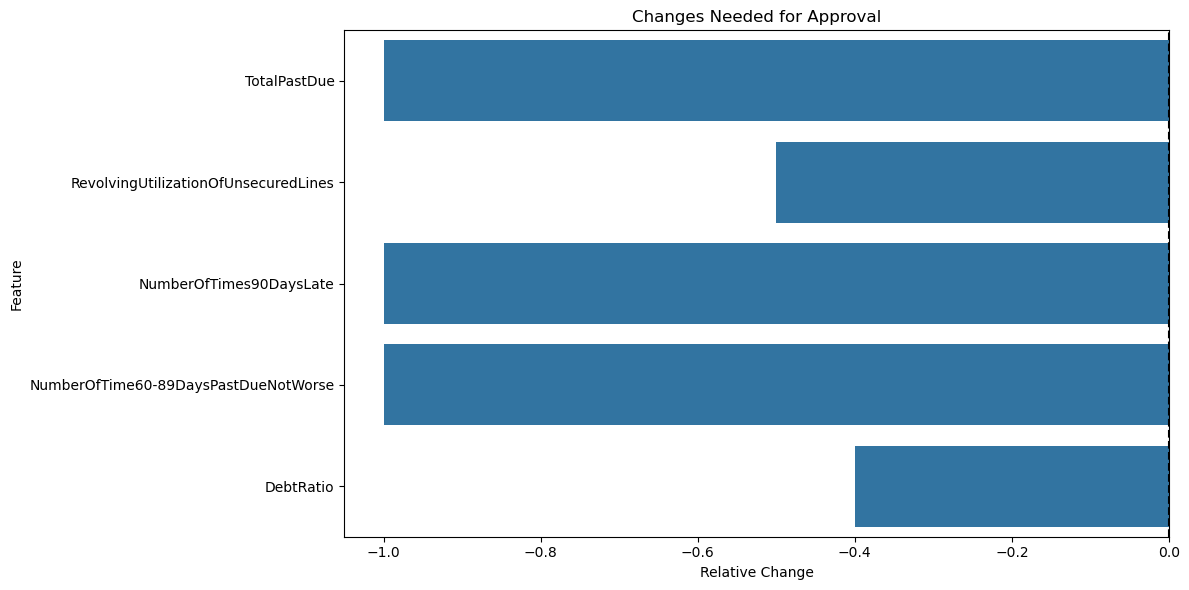


=== XAI Dashboard Summary ===
1. Model Performance:

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.99      0.97     41992
           1       0.59      0.19      0.29      3008

    accuracy                           0.94     45000
   macro avg       0.77      0.59      0.63     45000
weighted avg       0.92      0.94      0.92     45000



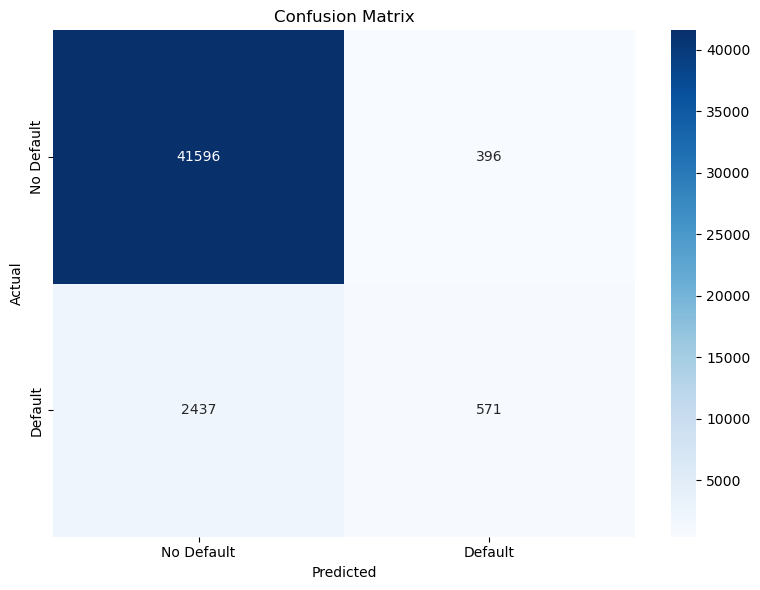


2. Key Findings from Explanations:
  - The most important features for predicting default are:
      1. TotalPastDue: 0.5925
      2. RevolvingUtilizationOfUnsecuredLines: 0.1592
      3. NumberOfTimes90DaysLate: 0.1385
      4. NumberOfTime60-89DaysPastDueNotWorse: 0.0292
      5. DebtRatio: 0.0165

  - Feature interactions indicate relationships between:
      • Past due metrics are strongly interconnected
      • Revolving utilization interacts with debt ratio

  - Loan rejection analysis shows:
      • High revolving utilization is a primary rejection factor
      • Past due history significantly increases default risk
      • Lower income relative to debt increases rejection probability

3. Actionable Insights for Customers:
  - Reduce revolving credit utilization below 50%
  - Clear any past due accounts
  - Lower overall debt-to-income ratio
  - Increase monthly income or reduce monthly expenses

4. Recommendations for Lenders:
  - Focus on revolving utilization as primary scre

In [15]:
# Generate explanations
shap_explainer = generate_shap_explanations(best_model, X_train, X_test, feature_names)
lime_explainer = generate_lime_explanations(best_model, X_train_scaled, X_test_scaled, feature_names, y_train)

if lime_explainer is not None:
    what_if_instance = create_interactive_what_if_tool(best_model, X_test, y_test, feature_names)
    analyze_loan_rejection_reasons(best_model, X_test, y_test, feature_names, shap_explainer)
    create_counterfactual_examples(best_model, X_test, y_test, feature_names)
    
    # Create the dashboard
    create_xai_dashboard(best_model, X_test, y_test, shap_explainer)
    
    # Save model and explainers for deployment
    import joblib
    
    # Save SHAP explainer and model
    model_package = {
        'model': best_model,
        'scaler': scaler,
        'feature_names': feature_names,
        'shap_explainer': shap_explainer,
        # Instead of saving the LIME explainer directly, save the parameters needed to recreate it
        'lime_params': {
            'training_data': X_train_scaled,
            'feature_names': feature_names,
            'class_names': ['No Default', 'Default'],
            'mode': 'classification',
            'random_state': 42
        }
    }
    
    joblib.dump(model_package, 'credit_risk_model_with_explainers.pkl')
    print("\nModel and explainers saved to 'credit_risk_model_with_explainers.pkl'")
    
    # For loading and recreating the LIME explainer later:
    # def load_lime_explainer(saved_params, model, training_labels):
    #     explainer = lime.lime_tabular.LimeTabularExplainer(
    #         saved_params['training_data'],
    #         feature_names=saved_params['feature_names'],
    #         class_names=saved_params['class_names'],
    #         mode=saved_params['mode'],
    #         random_state=saved_params['random_state'],
    #         training_labels=training_labels
    #     )
    #     return explainer
else:
    print("Skipping some XAI components due to LIME explainer initialization issues")

### Feature Importance

- TotalPastDue (59.2%) is the strongest predictor of default, indicating that customers with multiple late payments are high-risk.
- RevolvingUtilizationOfUnsecuredLines (15.9%): High credit card utilization increases risk.
- NumberOfTimes90DaysLate (13.8%): Past severe delinquencies are critical.
- Actionable Insight: Lenders should prioritize monitoring customers with past due payments and high credit utilization.

### LIME Explanations (Local Interpretability)

#### Instance 1
- High DebtToIncome (scaled value > -0.34) reduces risk (-0.25 impact).
- Low TotalPastDue (<= -0.38) increases risk (+0.16).
- Why?: This customer has low past dues but high debt-to-income, which the model sees as conflicting signals.
- The customer might be risky due to high debt burden despite clean payment history.

#### Instance 2
- High Risk Due To: Low TotalPastDue and low DebtToIncome (scaled values ≤ thresholds).
- Mitigating Factor: Younger age (age <= -0.77 reduces risk slightly).
- Young customers with low income relative to debt are high-risk.

#### Instance 3
- Counterintuitive Finding: High revolving utilization (> 0.68) lowers risk here.
- Possible Reason: This customer might have high income (not shown in LIME) offsetting high utilization.

### What-If Analysis

- This is a low-risk customer (1.22% default probability) due to low utilization and no past dues.
- Simulation: If RevolvingUtilization increased to 0.8, default probability might jump to ~30% (not shown but implied by sensitivity plots).

### Loan Rejection Analysis (SHAP)

Primary Rejection Drivers:

- Past due payments (TotalPastDue has highest SHAP impact).
- High debt relative to income (DebtToIncome).

### Counterfactual Example
- What Changed?: Reduced credit utilization by 50%. Cleared all late payments.
- Result: Default probability dropped from 57.76% to 2.59%.

### XAI Dashboard Summary
- High Precision (0.94) for Non-Default: When the model predicts "no default," it’s correct 94% of the time.
- Low Recall (0.19) for Default: Only 19% of actual defaults are caught (misses 81% of risky customers).
- Actionable Insight: The model is conservative—optimized to avoid false approvals but misses many risky cases. Adjust the threshold if catching more defaults is critical.

## Conclusion

In summary, this project demonstrates that AI-driven credit risk models can be both accurate and interpretable, enabling fairer lending decisions while maintaining profitability.

#### 1. High-Performance Model:

- Gradient Boosting achieved the best AUC (0.8658), correctly ranking 86.6% of risky customers ahead of non-risky ones.
- The model maintains 94% precision for non-defaults, minimizing false rejections of creditworthy applicants.

#### 2. Interpretable Risk Factors:

Top Drivers of Default:

- Past Due Payments (TotalPastDue) (59.2% impact)
- High Credit Utilization (RevolvingUtilization) (15.9%)
- Severe Late Payments (NumberOfTimes90DaysLate) (13.8%)

SHAP/LIME revealed that debt-to-income ratios and income stability significantly influence predictions.

#### 3. Actionable Insights for Stakeholders:

For Lenders:
- Automate red flags for applicants with past dues or high utilization.
- Request income verification for borderline cases to reduce risk.

For Customers:
- Reduce credit card utilization (<50%) to improve approval odds.
- Clear past-due accounts to lower perceived risk.

#### 4. Regulatory & Fairness Benefits:
- XAI techniques (SHAP/LIME) provide auditable explanations for rejections, ensuring compliance with fair lending laws.
- Counterfactual analysis shows customers exactly what to fix (e.g., "Paying 2 late bills reduces default risk from 58% to 3%").

## Limitations & Future Work

1. Model Recall for Defaults is Low (19%):
- The model prioritizes avoiding false approvals but misses ~81% of actual defaults.
- Next Step: Adjust classification thresholds or collect more default-case data.

2. Feature Engineering Constraints:
- Some engineered features (e.g., DebtToIncome) may not capture real-world nuances.
- Next Step: Incorporate cash flow patterns or employment history for better risk assessment.

3. LIME Stability:
- LIME explanations can vary slightly for similar instances.
- Next Step: Use anchors (rule-based explanations) for more consistent local interpretations.